In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas
from astropy import units as u
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file
import scipy
import scipy as stats
from astroquery.gaia import Gaia
from read_mist_models import ISOCMD
import glob


#copy and paste code cite vespa anyways

In [1]:
file = r'C:\Users\astro\SSG_Spectra\Metallicities\ssg_table1.txt'
gaia_ids = np.genfromtxt(file, usecols= 0, dtype = str)
gaia_ids2 = list(np.genfromtxt(file, usecols= 0, dtype = np.int64))
gaia_ids = str(list(gaia_ids)).strip('[]')#
#classif = np.genfromtxt(file, usecols= 17, dtype = str)

#print(gaia_ids)


#print(df.columns.tolist())

In [2]:
#Do Not Mess with Query

query_text = f'''SELECT TOP 10000 *
FROM gaiadr3.gaia_source 
WHERE gaiadr3.gaia_source.source_id IN ({gaia_ids})'''
job = Gaia.launch_job(query_text) 
gaia_data = job.get_results()


In [3]:
print(job)

<Table length=1895>
              name               dtype       unit                                                                  description                                                              n_bad
------------------------------- ------- ------------- ------------------------------------------------------------------------------------------------------------------------------------- -----
                    solution_id   int64                                                                                                                                 Solution Identifier     0
                    DESIGNATION  object                                                                                         Unique source designation (unique across all Data Releases)     0
                      SOURCE_ID   int64                                                                                  Unique source identifier (unique within a particular Data Release)     0
          

In [4]:
gaia_data['SOURCE_ID', 'ra','dec', 'rv_template_fe_h', 'mh_gspphot'] #Create tables 

SOURCE_ID,ra,dec,rv_template_fe_h,mh_gspphot
,deg,deg,dex,dex
int64,float64,float64,float32,float32
18910470421959808,40.65095558618673,7.290585245493459,-0.25,--
34148700855166720,43.83780066505116,15.656337721802666,0.0,--
54254958891842816,51.01410355127157,15.47253974991323,-0.25,-0.4777
65719566637012992,58.44664614163716,23.83542417189985,-0.5,-1.4311
71640436752289408,56.90332442047046,28.10701870991814,--,-0.3814
81709523719057536,40.68759334849107,16.305496512913244,--,-0.5055
83339790224838784,41.88059999692063,17.268300455125537,-0.5,-0.1972
83540210579216128,42.762736423881336,18.213725388984724,--,-0.3595


In [5]:
#ra = gaia_data['ra']
#dec = gaia_data['dec']
c = SkyCoord(ra=gaia_data['ra'], dec=gaia_data['dec'], frame='icrs')
ra = c.ra.wrap_at(180 * u.deg).radian
dec = c.dec.radian

dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
m_G = np.array(gaia_data['phot_g_mean_mag'], dtype = float)
uncorr_bp_rp = np.array(gaia_data['bp_rp'], dtype = float)
distance = np.array(dist, dtype = float)

In [6]:
av_tot = np.genfromtxt(file, usecols=16, dtype=float)
av = np.array([av_tot[gaia_ids2.index(item)] for item in gaia_data['SOURCE_ID']], 
              dtype = float)
ag = av*0.789
Ebp_rp = ag/1.890 #ag/e(bp=rp) = 1.890
bp_rp = uncorr_bp_rp + Ebp_rp
M_G = -5*np.log10(distance) + m_G - ag + 5 #m-M = 5log(d) - 5 + Av

In [7]:
raw_leiner2022_class = np.genfromtxt(file, usecols=17, dtype=str)
leiner2022_class = np.array([raw_leiner2022_class[gaia_ids2.index(item)] for item in gaia_data['SOURCE_ID']], 
              dtype = str)

In [13]:
raw_star_name1 = np.genfromtxt(file, usecols=1, dtype = str)
raw_star_name2 = np.genfromtxt(file, usecols=2, dtype = str)
star_name1 = np.array([raw_star_name1[gaia_ids2.index(item)] for item in gaia_data['SOURCE_ID']], dtype = str)
star_name2 = np.array([raw_star_name2[gaia_ids2.index(item)] for item in gaia_data['SOURCE_ID']], dtype = str)
star_name = np.array([star_name1[k] + ' ' + star_name2[k] for k in range(len(star_name1))])
print(star_name)

['HR Cet' 'DG Ari' 'CSS J032403.3+152821' ... 'ZTF J205114.59-054224.6'
 'CSS J204457.8-035836' 'V0365 Aqr']


In [18]:
star_data = {'Name': star_name, 'Gaia ID': gaia_data['SOURCE_ID'], 
             'ra': gaia_data['ra'], 'dec': gaia_data['dec'], 'class': leiner2022_class}
star_data2 = {'ra': gaia_data['ra'], 'dec': gaia_data['dec']}
df = pandas.DataFrame(star_data2)
print(df)

df.to_csv('leiner2022_sample2.csv', index=False)

              ra        dec
0      40.650956   7.290585
1      43.837801  15.656338
2      51.014104  15.472540
3      58.446646  23.835424
4      56.903324  28.107019
...          ...        ...
1890  316.070040  -7.610754
1891  319.097661  -4.955455
1892  312.810828  -5.706874
1893  311.240914  -3.977007
1894  313.538473  -2.759387

[1895 rows x 2 columns]


# SSG Analysis

In [8]:
ssg_file = r'C:\Users\astro\SSG_Spectra\Metallicities\SSG_Data2.csv'

df = pandas.read_csv(ssg_file, delimiter = ',')
print(df)

print(df.columns.tolist())

                       Star              Gaia ID      H-alpha Line  \
0                    29 Dra  1655646778064790528        Absorption   
1   2MASS J08171221+0736164  3097200805201566720        Absorption   
2   2MASS J08504952+1217158   605014833054650880          Emission   
3   2MASS J17270871+2700144  4571134418985782912        Absorption   
4                    54 Cam  1081565094046074624  Variable H-alpha   
..                      ...                  ...               ...   
70                 V498 And   387742126997049728  Variable H-alpha   
71                 V503 Hya   582882278166763648  Variable H-alpha   
72                 V832 Her  4573752837207321344        Absorption   
73                  V834Her  4597154602175212672        Absorption   
74                  V846Her  1302252161666670464        Absorption   

   Classification  RV Amplitude  Number of Observations  
0             cut         1.330                       4  
1              RS        13.865            

In [9]:
ssg_ids = np.array(df['Gaia ID'], dtype=np.int64)
raw_ssg_profile = np.array(df['H-alpha Line'], dtype=str)
raw_ssg_name = np.array(df['Star'], dtype = str)
raw_ssg_class = np.array(df['Classification'], dtype=str)
raw_ssg_rvs = np.array(df['RV Amplitude'], dtype=float)
raw_num_obs = np.array(df['Number of Observations'], dtype = int)

'''
ssg_profile = np.array([raw_ssg_profile[ssg_list.index(item)] for item in ssg_sample['SOURCE_ID']], 
              dtype = str)
ssg_name = np.array([raw_ssg_name[ssg_list.index(item)] for item in ssg_sample['SOURCE_ID']], 
              dtype = str)
ssg_class = np.array([raw_ssg_class[ssg_list.index(item)] for item in ssg_sample['SOURCE_ID']], 
              dtype = str)
ssg_rvs = np.array([raw_ssg_rvs[[ssg_list.index(item)] for item in ssg_sample['SOURCE_ID']], 
              dtype = float)
'''

'''
ssg_profile = np.array([raw_ssg_profile[ssg_list.index(item)] for item in ssg_ids if item in ssg_sample['SOURCE_ID']], 
              dtype = str)
ssg_name = np.array([raw_ssg_name[ssg_list.index(item)] for item in ssg_ids if item in ssg_sample['SOURCE_ID']], 
              dtype = str)
ssg_class = np.array([raw_ssg_class[ssg_list.index(item)] for item in ssg_ids if item in ssg_sample['SOURCE_ID']], 
              dtype = str)
'''

In [13]:
#av = np.array([av_tot[gaia_ids2.index(item)] for item in gaia_ids2 if item in gaia_data['SOURCE_ID']], 
              #dtype = float)

ssg_follow = [any(k == ssg_ids) for k in gaia_data['SOURCE_ID']]
ssg_sample = gaia_data[ssg_follow]
ssg_list = list(ssg_ids)


ssg_profile = np.array([raw_ssg_profile[ssg_list.index(item)] if item 
        in ssg_sample['SOURCE_ID'] else None for item in gaia_data['SOURCE_ID']], dtype = str)
ssg_name = np.array([raw_ssg_name[ssg_list.index(item)] if item 
        in ssg_sample['SOURCE_ID'] else None for item in gaia_data['SOURCE_ID']])
ssg_class = np.array([raw_ssg_class[ssg_list.index(item)] if item 
        in ssg_sample['SOURCE_ID'] else None for item in gaia_data['SOURCE_ID']])
ssg_rvs = np.array([raw_ssg_rvs[ssg_list.index(item)] if item 
        in ssg_sample['SOURCE_ID'] else -10000 for item in gaia_data['SOURCE_ID']], dtype = float)

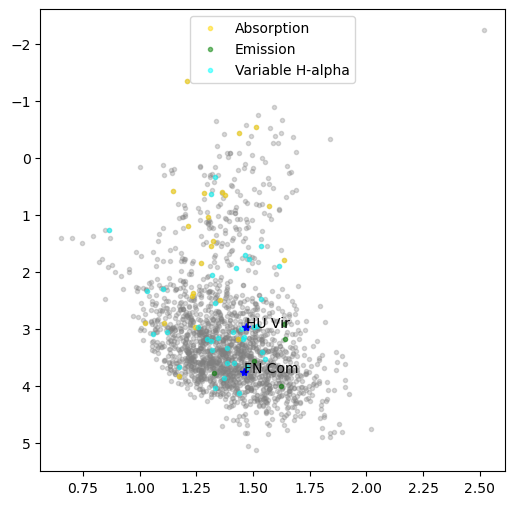

In [21]:
HUVir = gaia_data['SOURCE_ID'] == 3582095053777917952 #HU Vir
FNCom = gaia_data['SOURCE_ID'] == 3947234928261838720 
CGTri = gaia_data['SOURCE_ID'] == 326753999413912192
#Defining metallicty samples
variable_ha = (ssg_profile == 'Variable H-alpha')
absorption = (ssg_profile == 'Absorption')
emission = (ssg_profile == 'Emission')



#plotting colors for each sample

#plot a CMD with low and high mass samples highlighted
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(bp_rp, M_G, marker='.', linestyle='none', alpha=0.3, color = 'grey')
ax.plot(bp_rp[ssg_follow & absorption], M_G[ssg_follow & absorption], marker='.', linestyle='none', 
        alpha=0.5, color = 'gold', label = 'Absorption')
ax.plot(bp_rp[ssg_follow & emission], M_G[ssg_follow & emission], marker='.', linestyle='none', 
        alpha=0.5, color = 'green', label = 'Emission')
ax.plot(bp_rp[ssg_follow & variable_ha], M_G[ssg_follow & variable_ha], marker='.', linestyle='none', 
        alpha=0.5, color = 'cyan', label = 'Variable H-alpha')

ax.invert_yaxis()
#Highlight the targest stars
ax.plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', 
        alpha=1, color = 'blue')
ax.text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')
ax.plot(bp_rp[FNCom], M_G[FNCom], marker='*', linestyle='none', alpha=1, color = 'blue')
ax.text(bp_rp[FNCom], M_G[FNCom], 'FN Com')
#ax.plot(bp_rp[CGTri], M_G[CGTri], marker='*', linestyle='none', alpha=1, color = 'blue')
#ax.text(bp_rp[CGTri], M_G[CGTri], 'CG Tri')
#ax.text(bp_rp[Dra_29], M_G[Dra_29], '29 Dra')
ax.legend()

In [22]:
iso_file00 = r"C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bd9dbb9411.iso.cmd"
iso_file_low025 = r"C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdd54012f6.iso.cmd"
iso_file05 = r"C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdbe235892.iso.cmd"
iso_00 = ISOCMD(iso_file00)
iso_low025 = ISOCMD(iso_file_low025)
iso_05 = ISOCMD(iso_file05)

Reading in: C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bd9dbb9411.iso.cmd
Reading in: C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdd54012f6.iso.cmd
Reading in: C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdbe235892.iso.cmd


In [23]:
#age_ind = isocmd.age_index(9.6) #returns the index for the desired age
G_00 = iso_00.isocmds[0]['Gaia_G_EDR3']
BP_RP00 = iso_00.isocmds[0]['Gaia_BP_EDR3'] - iso_00.isocmds[0]['Gaia_RP_EDR3']

G_05 = iso_05.isocmds[0]['Gaia_G_EDR3']
BP_RP05 = iso_05.isocmds[0]['Gaia_BP_EDR3'] - iso_05.isocmds[0]['Gaia_RP_EDR3']

G_low025 = iso_low025.isocmds[0]['Gaia_G_EDR3']
BP_RP_low025 = iso_low025.isocmds[0]['Gaia_BP_EDR3'] - iso_low025.isocmds[0]['Gaia_RP_EDR3']

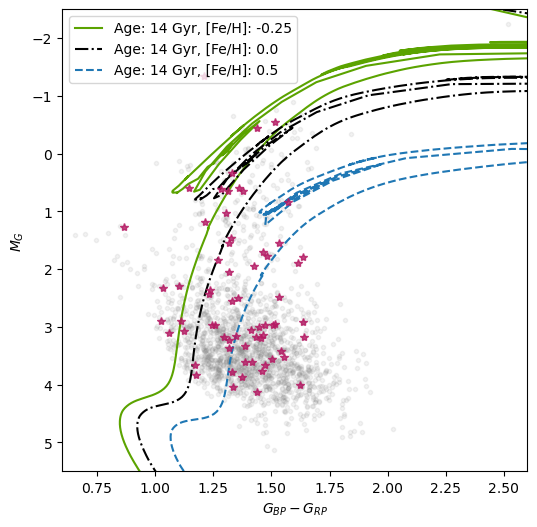

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#full Sample
ax.plot(bp_rp, M_G, marker='.', linestyle='none', alpha=0.1, color = 'grey')

ax.plot(BP_RP_low025, G_low025, color = '#5ba300', label='Age: 14 Gyr, [Fe/H]: -0.25')
ax.plot(BP_RP00, G_00, color = 'black', linestyle = '-.', label='Age: 14 Gyr, [Fe/H]: 0.0')
ax.plot(BP_RP05, G_05, color = 'tab:blue', linestyle = '--', label='Age: 14 Gyr, [Fe/H]: 0.5')

ax.plot(bp_rp[ssg_follow], M_G[ssg_follow], marker='*', linestyle='none', alpha=0.8, color = '#b51963')

#Highlight the targest stars
ax.set_xlim(0.60, 2.60)
ax.set_ylim(-2.5,5.5)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')
ax.invert_yaxis()
ax.legend()

fig.savefig("SSG_isocrone.png", dpi = 300)

## EB Sample

In [25]:
eb_path = r'EB_Sample.csv'

df2 = pandas.read_csv(eb_path, delimiter = ',')
print(df2.columns.tolist())




['Name', 'Gaia DR2', 'TIC', 'Type', 'RAJ2000', 'DecJ2000', 'distance (pc)', 'Prot', 'g', 'bp-rp', 'Observed?', 'n_obs_coude_060721', 'n_obs_nres', 'n_obs_igrins', 'RUWE']


In [26]:
eb_sample_ids = np.array(df2['Gaia DR2'], dtype = np.int64)

eb_sample = np.array([any(eb_sample_ids == k) for k in gaia_data['SOURCE_ID']])

raw_eb_rvs = np.array(df2['n_obs_igrins'], dtype = float) #excludes HUVir, FN Com
#ssg_rvs = np.array([raw_ssg_rvs[ssg_list.index(item)] for item in ssg_sample['SOURCE_ID']],  dtype = float)


eb_rvs = np.array([raw_eb_rvs[list(eb_sample_ids).index(item)] for item in gaia_data[eb_sample]['SOURCE_ID']], 
              dtype = int)

leiner2022_sample = (leiner2022_class == 'SSG')
print(eb_sample)

print(any(leiner2022_sample))

eb_rv_samp = (eb_rvs > 0)

rv_samp = (ssg_rvs > -1)

print(eb_rv_samp)
print(len(M_G[eb_sample]))

[False False False ... False False False]
True
[ True False False False False False False  True  True  True False False
 False  True  True]
15


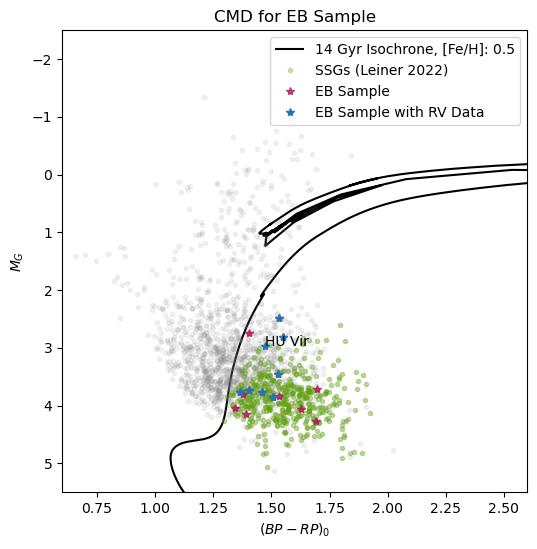

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title('CMD for EB Sample')

ax.plot(BP_RP05, G_05, color = 'black', linestyle = '-', label='14 Gyr Isochrone, [Fe/H]: 0.5')
ax.plot(bp_rp, M_G, marker='.', linestyle='none', alpha=0.1, color = 'grey')
'''
ax.plot(bp_rp[ssg_follow][rv_samp], M_G[ssg_follow][rv_samp], marker='.', linestyle='none', 
        alpha=0.3, color = '#5ba300', label = 'SSG RV Sample')
'''

ax.plot(bp_rp[leiner2022_sample], M_G[leiner2022_sample], marker='.', linestyle='none', 
        alpha=0.3, color = '#5ba300', label = 'SSGs (Leiner 2022)')
#ax.plot(BP_RP_low025, G_low025, color = '#5ba300', label='Age: 14 Gyr, [Fe/H]: -0.25')
#ax.plot(BP_RP00, G_00, color = 'black', linestyle = '-.', label='Age: 14 Gyr, [Fe/H]: 0.0')


ax.plot(bp_rp[eb_sample], M_G[eb_sample], marker='*', 
        linestyle='none', alpha=0.8, color = '#b51963', label = 'EB Sample')
ax.plot(bp_rp[eb_sample][eb_rv_samp], M_G[eb_sample][eb_rv_samp], marker='*', 
        linestyle='none', alpha=1, color = 'tab:blue')
'''
ax.plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', 
        alpha=1, color = '#B51963')
#ax.plot(bp_rp[FNCom], M_G[FNCom], marker='*', linestyle='none', alpha=1, color = 'tab:blue')#'#B51963')
'''
#Highlight the targest stars

ax.plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', 
        alpha=1, color = 'tab:blue', label = 'EB Sample with RV Data')#with Coudé Data')
ax.plot(bp_rp[FNCom], M_G[FNCom], marker='*', 
        linestyle='none', alpha=1, color = 'tab:blue')
#ax.text(bp_rp[FNCom], M_G[FNCom], 'FN Com')
ax.text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')

ax.set_xlim(0.60, 2.60)
ax.set_ylim(-2.5,5.5)
ax.set_xlabel('$(BP-RP)_0$')
ax.set_ylabel('$M_G$')
ax.invert_yaxis()
ax.legend()
#fig.savefig("EB_isocrone4.png", dpi = 300)

In [28]:
print(eb_sample)

[False False False ... False False False]


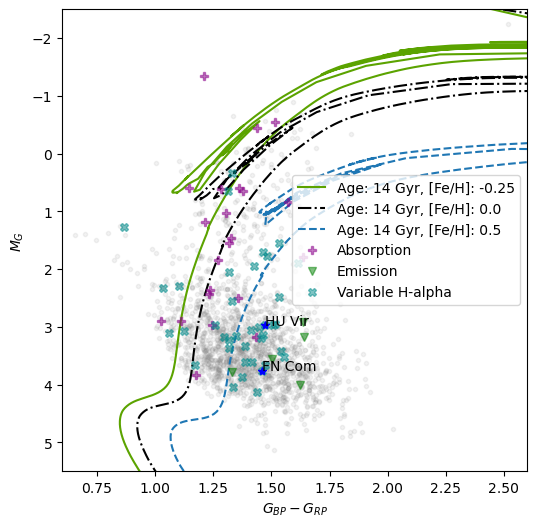

In [30]:
emis_color = 'green'
abs_color = 'darkmagenta'
var_color = 'darkcyan'



fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#full Sample
ax.plot(bp_rp, M_G, marker='.', linestyle='none', alpha=0.1, color = 'grey')

ax.plot(BP_RP_low025, G_low025, color = '#5ba300', label='Age: 14 Gyr, [Fe/H]: -0.25')
ax.plot(BP_RP00, G_00, color = 'black', linestyle = '-.', label='Age: 14 Gyr, [Fe/H]: 0.0')
ax.plot(BP_RP05, G_05, color = 'tab:blue', linestyle = '--', label='Age: 14 Gyr, [Fe/H]: 0.5')


ax.plot(bp_rp[ssg_follow & absorption], M_G[ssg_follow & absorption], marker='P', linestyle='none', 
        alpha=0.5, color = abs_color, label = 'Absorption')
ax.plot(bp_rp[ssg_follow & emission], M_G[ssg_follow & emission], marker='v', linestyle='none', 
        alpha=0.5, color = emis_color, label = 'Emission')
ax.plot(bp_rp[ssg_follow & variable_ha], M_G[ssg_follow & variable_ha], marker='X', linestyle='none', 
        alpha=0.5, color = var_color, label = 'Variable H-alpha')

#Highlight the targest stars

ax.plot(bp_rp[HUVir], M_G[HUVir], marker='*', linestyle='none', 
        alpha=1, color = 'blue')
ax.plot(bp_rp[FNCom], M_G[FNCom], marker='*', linestyle='none', 
        alpha=1, color = 'blue')
ax.text(bp_rp[FNCom], M_G[FNCom], 'FN Com')
ax.text(bp_rp[HUVir], M_G[HUVir], 'HU Vir')

ax.set_xlim(0.60, 2.60)
ax.set_ylim(-2.5,5.5)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')
ax.invert_yaxis()
ax.legend()


In [31]:
print(max(gaia_data[ssg_follow]['mh_gspphot']))
print(min(gaia_data[ssg_follow]['mh_gspphot']))
print(np.mean(gaia_data[ssg_follow]['mh_gspphot']))

0.1155
-0.6495
-0.1578787235503501


In [33]:
periods_tot = np.genfromtxt(file, usecols= 12, dtype = float)


#names = np.genfromtxt(file, usecols= 1, dtype = str) + np.genfromtxt(file, usecols= 2, dtype = str)
periods = np.array([periods_tot[gaia_ids2.index(item)] for item in gaia_data['SOURCE_ID']], 
              dtype = float)

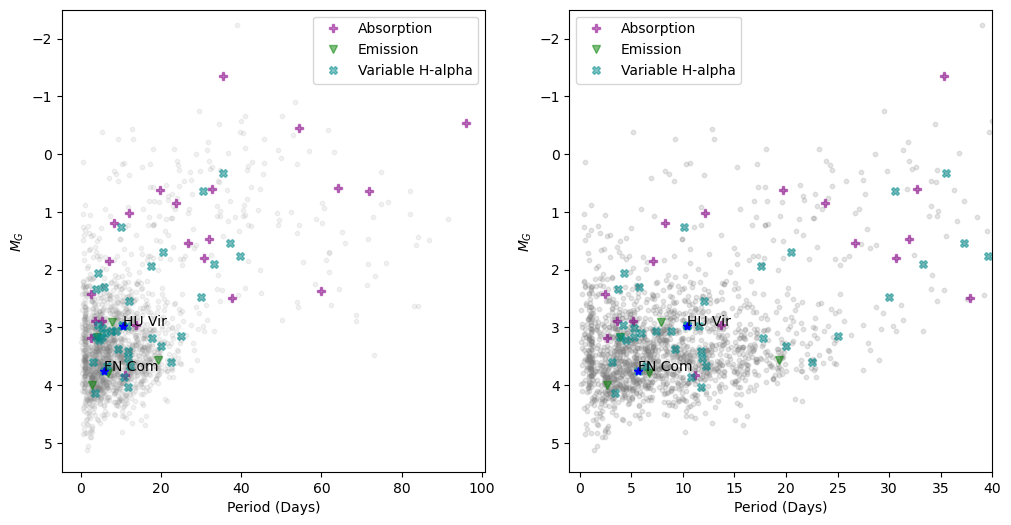

In [35]:
#highlight HU Vir, FN Com


#plotting colors for each sample

#plot a CMD with low and high mass samples highlighted
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(periods, M_G, s=10, color = 'grey', alpha = 0.1)#, vmax=30)

ax[0].plot(periods[ssg_follow & absorption], M_G[ssg_follow & absorption], marker='P', linestyle='none', 
        alpha=0.5, color = abs_color, label = 'Absorption')
ax[0].plot(periods[ssg_follow & emission], M_G[ssg_follow & emission], marker='v', linestyle='none', 
        alpha=0.5, color = emis_color, label = 'Emission')
ax[0].plot(periods[ssg_follow & variable_ha], M_G[ssg_follow & variable_ha], marker='X', linestyle='none', 
        alpha=0.5, color = var_color, label = 'Variable H-alpha')
ax[0].set_ylim(-2.5,5.5)


ax[0].plot(periods[HUVir], M_G[HUVir], marker='*', linestyle='none', color='b', alpha = 1.0)
ax[0].text(periods[HUVir], M_G[HUVir], 'HU Vir')

ax[0].plot(periods[FNCom], M_G[FNCom], marker='*', linestyle='none', color='b', alpha = 1.0)
ax[0].text(periods[FNCom], M_G[FNCom], 'FN Com')

ax[0].invert_yaxis()
ax[0].set_xlabel('Period (Days)')
ax[0].set_ylabel('$M_G$')
ax[0].legend()

#Plot 1
ax[1].scatter(periods, M_G, s=10, color = 'grey', alpha = 0.1)#, vmax=30)
ax[1].scatter(periods, M_G, s=10, color = 'grey', alpha = 0.1)#, vmax=30)

ax[1].plot(periods[ssg_follow & absorption], M_G[ssg_follow & absorption], marker='P', linestyle='none', 
        alpha=0.5, color = abs_color, label = 'Absorption')
ax[1].plot(periods[ssg_follow & emission], M_G[ssg_follow & emission], marker='v', linestyle='none', 
        alpha=0.5, color = emis_color, label = 'Emission')
ax[1].plot(periods[ssg_follow & variable_ha], M_G[ssg_follow & variable_ha], marker='X', linestyle='none', 
        alpha=0.5, color = var_color, label = 'Variable H-alpha')

ax[1].plot(periods[HUVir], M_G[HUVir], marker='*', linestyle='none', color='b', alpha = 1.0)
ax[1].text(periods[HUVir], M_G[HUVir], 'HU Vir')
ax[1].plot(periods[FNCom], M_G[FNCom], marker='*', linestyle='none', color='b', alpha = 1.0)
ax[1].text(periods[FNCom], M_G[FNCom], 'FN Com')

ax[1].set_ylim(-2.5,5.5)
ax[1].set_xlim(-1, 40)
ax[1].invert_yaxis()
ax[1].set_xlabel('Period (Days)')
ax[1].set_ylabel('$M_G$')
ax[1].legend()
#ax.legend()
#Paper here finds gaia metallicty is accurate for the most part

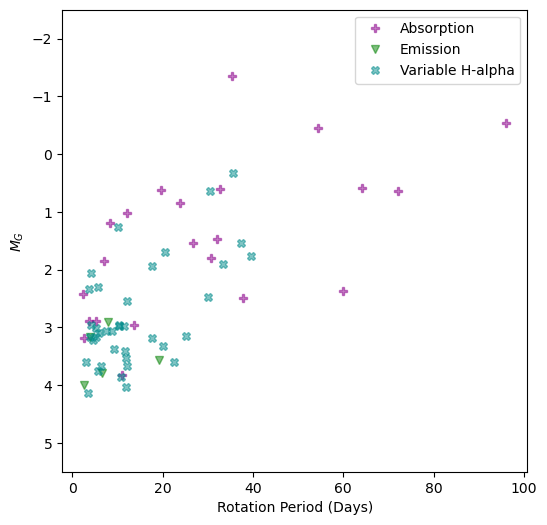

In [41]:

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

#ax[0].scatter(periods, M_G, s=10, color = 'grey', alpha = 0.1)#, vmax=30)


ax.plot(periods[absorption], M_G[absorption], marker='P', linestyle='none', 
        alpha=0.5, color = abs_color, label = 'Absorption')
ax.plot(periods[emission], M_G[emission], marker='v', linestyle='none', 
        alpha=0.5, color = emis_color, label = 'Emission')
ax.plot(periods[variable_ha], M_G[variable_ha], marker='X', linestyle='none', 
        alpha=0.5, color = var_color, label = 'Variable H-alpha')
ax.set_ylim(-2.5,5.5)
#ax.set_xscale('log')
ax.invert_yaxis()
ax.set_xlabel('Rotation Period (Days)')
ax.set_ylabel('$M_G$')
ax.legend()



#fig.savefig("SSG_rotation.png", dpi = 300)

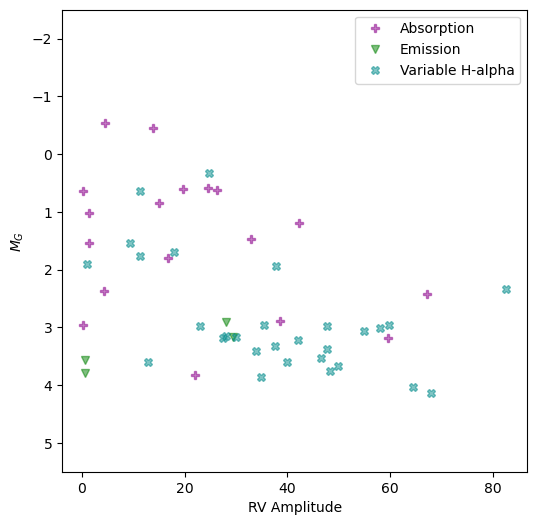

In [37]:
#highlight HU Vir, FN Com


#plotting colors for each sample

#plot a CMD with low and high mass samples highlighted
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

#ax.scatter(periods, M_G, s=10, color = 'grey', alpha = 0.1)#, vmax=30)

ax.plot(ssg_rvs[absorption], M_G[absorption], marker='P', linestyle='none', 
        alpha=0.5, color = abs_color, label = 'Absorption')
ax.plot(ssg_rvs[emission], M_G[emission], marker='v', linestyle='none', 
        alpha=0.5, color = emis_color, label = 'Emission')
ax.plot(ssg_rvs[variable_ha], M_G[variable_ha], marker='X', linestyle='none', 
        alpha=0.5, color = var_color, label = 'Variable H-alpha')
ax.set_ylim(-2.5,5.5)
#ax.set_xticks(np.arange(min(ssg_rvs), max(ssg_rvs), 5))


#ax[0].plot(periods[HUVir], M_G[HUVir], marker='*', linestyle='none', color='b', alpha = 1.0)
#ax[0].text(periods[HUVir], M_G[HUVir], 'HU Vir')

#ax[0].plot(periods[FNCom], M_G[FNCom], marker='*', linestyle='none', color='b', alpha = 1.0)
#ax[0].text(periods[FNCom], M_G[FNCom], 'FN Com')

ax.invert_yaxis()
ax.set_xlabel('RV Amplitude')
ax.set_ylabel('$M_G$')
ax.legend()



[26, 7, 41]
[15, 4, 24]
[5, 4, 19]
[2, 3, 12]


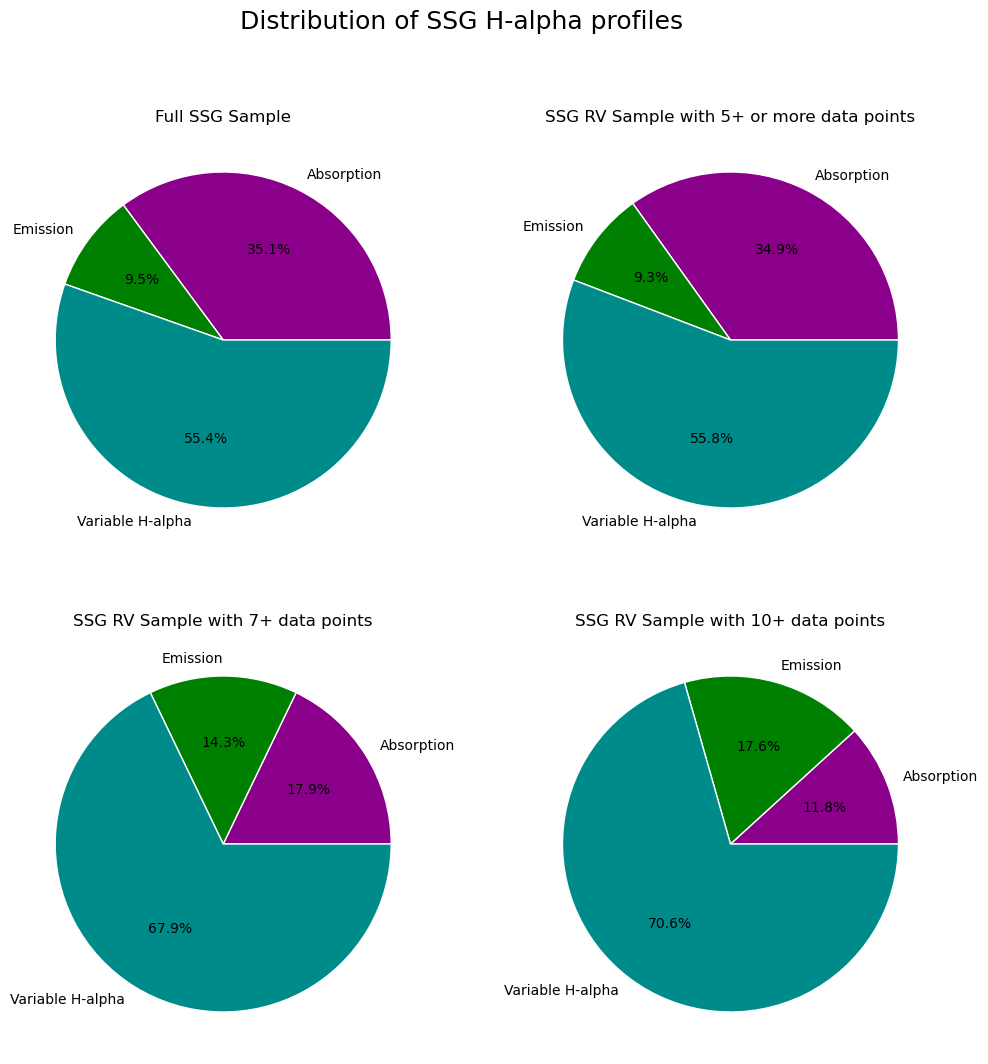

In [38]:
raw_absorb = (raw_ssg_profile == 'Absorption')# & (raw_ssg_rvs > 0)
raw_emis = (raw_ssg_profile == 'Emission') #& (raw_ssg_rvs > 0)
raw_var = (raw_ssg_profile == 'Variable H-alpha') #& (raw_ssg_rvs > 0)


ssg_cuts = ((raw_ssg_rvs > 0) & (raw_num_obs > 4))
ssg_cuts2 = ((raw_ssg_rvs > 0) & (raw_num_obs > 6))
ssg_cuts3 = ((raw_ssg_rvs > 0) & (raw_num_obs > 9))

prof_dat = [len(ssg_ids[raw_absorb]), len(ssg_ids[raw_emis]), len(ssg_ids[raw_var])-1]


prof_dat2 = [len(ssg_ids[raw_absorb & ssg_cuts]),
             len(ssg_ids[raw_emis & ssg_cuts]),
             len(ssg_ids[raw_var & ssg_cuts])-1]

prof_dat3 = [len(ssg_ids[raw_absorb & ssg_cuts2]),
             len(ssg_ids[raw_emis & ssg_cuts2]),
             len(ssg_ids[raw_var & ssg_cuts2])-1]

prof_dat4 = [len(ssg_ids[raw_absorb & ssg_cuts3]),
             len(ssg_ids[raw_emis & ssg_cuts3]),
             len(ssg_ids[raw_var & ssg_cuts3])-1]

wp = {'linewidth': 1, 'edgecolor': "white"}
prof_labels = ['Absorption', 'Emission', 'Variable H-alpha']
prof_colors = [abs_color, emis_color, var_color]

print(prof_dat)
print(prof_dat2)
print(prof_dat3)
print(prof_dat4)

#plot
fig, ax = plt.subplots(2, 2, figsize = (12, 12))
fig.suptitle('Distribution of SSG H-alpha profiles', fontsize = 18)

ax[0,0].set_title('Full SSG Sample')
ax[0,0].pie(prof_dat, labels= prof_labels, autopct='%1.1f%%',
         colors = prof_colors, wedgeprops = wp)

ax[0,1].set_title('SSG RV Sample with 5+ or more data points')
ax[0,1].pie(prof_dat2, labels= prof_labels, autopct='%1.1f%%',
          colors = prof_colors, wedgeprops = wp)

ax[1,0].set_title('SSG RV Sample with 7+ data points')
ax[1,0].pie(prof_dat3, labels= prof_labels, autopct='%1.1f%%',
          colors = prof_colors, wedgeprops = wp)
ax[1,1].set_title('SSG RV Sample with 10+ data points')
ax[1,1].pie(prof_dat4, labels= prof_labels, autopct='%1.1f%%',
          colors = prof_colors, wedgeprops = wp)
plt.show()


#fig.savefig("SSG_ha_pie.png", dpi = 300)

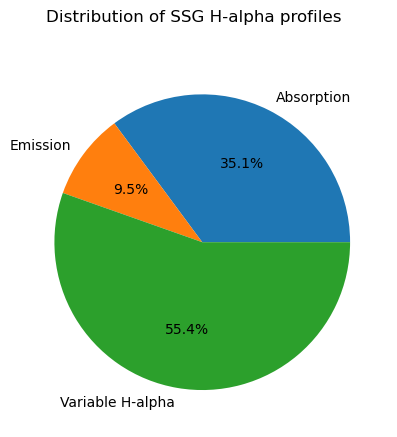

In [39]:
#plot
'''
fig = plt.figure(figsize=(10, 7))
plt.pie(prof_dat, labels=['Absorption', 'Emission', 'Variable H-alpha'])
'''

fig, ax = plt.subplots()
fig.suptitle('Distribution of SSG H-alpha profiles')
ax.pie(prof_dat, labels=['Absorption', 'Emission', 'Variable H-alpha'], autopct='%1.1f%%')
plt.show()
